In [5]:
# 使用Prophet預測股票
# basic
import numpy as np
import pandas as pd

# get data
import pandas_datareader as pdr

# visual
import matplotlib.pyplot as plt
%matplotlib inline
#time
import datetime as datetime

#Prophet
from fbprophet import Prophet

from sklearn import metrics

請輸入股票-->1314.TW
                 High        Low       Open      Close       Volume  Adj Close
Date                                                                          
2015-01-05  11.666666  10.904761  11.000000  11.571428  105299250.0  10.662335
2015-01-06  11.952380  11.238095  11.428571  11.857142   98024850.0  10.925603
2015-01-07  12.190476  11.619047  11.904761  11.619047   83179950.0  10.706213
2015-01-08  12.000000  11.714285  11.714285  11.761904   61997250.0  10.837847
2015-01-09  11.904761  11.619047  11.809523  11.666666   45198300.0  10.750092


Text(0.5, 1.0, '1314.TW')

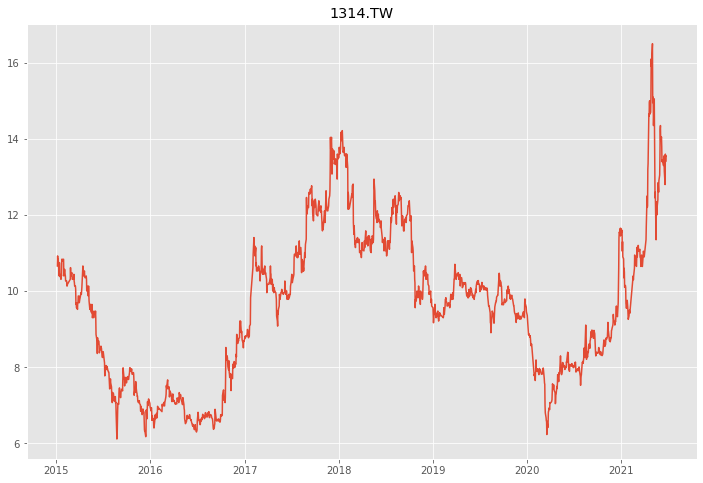

In [3]:
# 讀取股票
start = datetime.datetime(2015,1,1)
stock = str(input("請輸入股票-->"))
df_stock = pdr.DataReader(stock,'yahoo', start)
print(df_stock.head())
plt.style.use('ggplot')
fig = plt.figure(figsize=(12,8))
plt.plot(df_stock['Adj Close'])
plt.title(stock)

In [6]:
new_df_stock = pd.DataFrame(df_stock['Adj Close']).reset_index().rename(columns={'Date':'ds','Adj Close':'y'})
print(new_df_stock.head())

          ds          y
0 2015-01-05  10.662335
1 2015-01-06  10.925603
2 2015-01-07  10.706213
3 2015-01-08  10.837847
4 2015-01-09  10.750092


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2015-01-05  2.388041    2.349815    2.479996     2.388041     2.388041   
1 2015-01-06  2.386493    2.338499    2.471482     2.386493     2.386493   
2 2015-01-07  2.384944    2.337685    2.466444     2.384944     2.384944   
3 2015-01-08  2.383396    2.337092    2.467425     2.383396     2.383396   
4 2015-01-09  2.381848    2.326734    2.458529     2.381848     2.381848   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0        0.024204              0.024204              0.024204  0.009245   
1        0.022353              0.022353              0.022353  0.009290   
2        0.019268              0.019268              0.019268  0.008372   
3        0.017848              0.017848              0.017848  0.009348   
4        0.013269              0.013269              0.013269  0.007350   

   weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0      0.009245      

Text(0.5, 1.0, '1314.TW一年預測走勢')

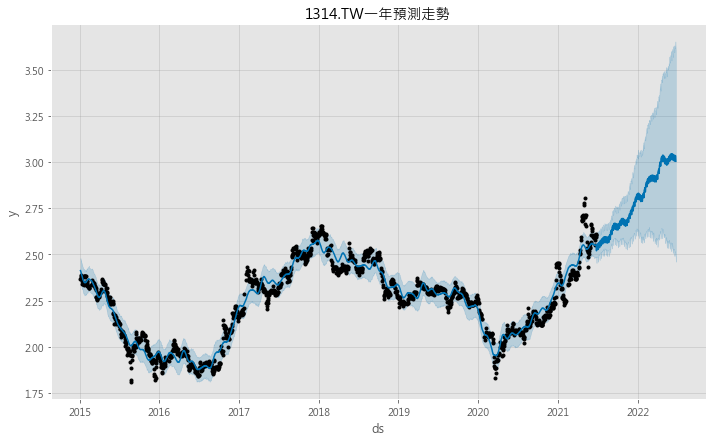

In [7]:
# 使用Prophet來預測股票
new_df_stock['y'] = np.log(new_df_stock['y'])
# 定義模型
model = Prophet()
# 訓練模型
model.fit(new_df_stock)
# 建立預測集
future = model.make_future_dataframe(periods=365)
# 進行預測
forecast = model.predict(future)
print(forecast.head())
plt.rcParams['font.sans-serif']=['Microsoft JhengHei']
model.plot(forecast,figsize=(10, 6))
plt.title(stock+"一年預測走勢")

            Adj Close      yhat  yhat_upper  yhat_lower
ds                                                     
2018-03-13  11.276627  2.500897    2.562859    2.434516
2018-03-14  11.364382  2.497153    2.564504    2.431348
2018-03-15  11.408260  2.495220    2.559695    2.424729
2018-03-16  11.320504  2.490246    2.555131    2.427832
2018-03-19  11.276627  2.483042    2.552099    2.420571
            Adj Close       yhat  yhat_upper  yhat_lower
ds                                                      
2018-03-13  11.276627  12.193422   12.972859   11.410293
2018-03-14  11.364382  12.147857   12.994218   11.374203
2018-03-15  11.408260  12.124405   12.931878   11.299168
2018-03-16  11.320504  12.064249   12.872980   11.334280
2018-03-19  11.276627  11.977642   12.834013   11.252281


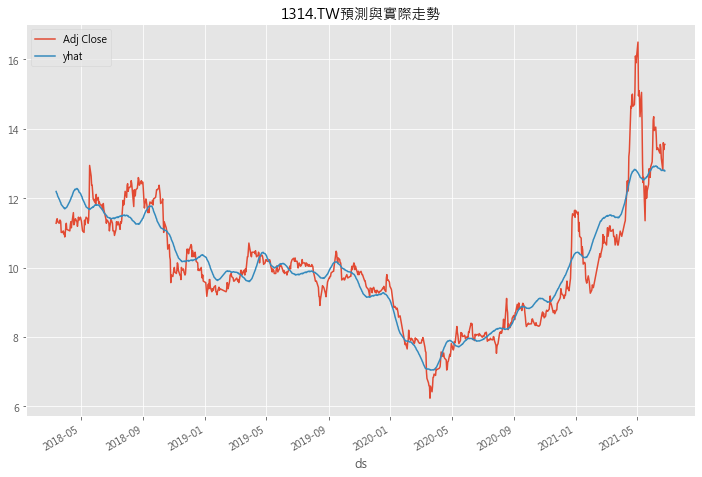

In [8]:
# 看預測和實際數據的最後800筆(一年252筆)
df_stock_close = pd.DataFrame(df_stock['Adj Close'])
two_years = forecast.set_index('ds').join(df_stock_close)
two_years = two_years[['Adj Close','yhat','yhat_upper','yhat_lower']].dropna().tail(800)
print(two_years.head())
two_years['yhat']=np.exp(two_years.yhat)
two_years['yhat_upper']=np.exp(two_years.yhat_upper)
two_years['yhat_lower']=np.exp(two_years.yhat_lower)
print(two_years.head())
two_years[['Adj Close', 'yhat']].plot(figsize=(12, 8))
plt.title(stock+"預測與實際走勢")
plt.show()

In [9]:
two_years_AE = (two_years.yhat-two_years['Adj Close'])
print(two_years_AE.describe())
# MSE：均方誤差( MSE越接近0越好 )
print('MSE:', metrics.mean_squared_error(two_years.yhat,two_years['Adj Close']))
# MAE：平均絕對誤差
print('MAE:', metrics.mean_absolute_error(two_years.yhat,two_years['Adj Close']))

count    800.000000
mean      -0.005992
std        0.594623
min       -3.767541
25%       -0.262676
50%        0.038168
75%        0.367449
max        1.386190
dtype: float64
MSE: 0.35317045536027863
MAE: 0.42732010304168727


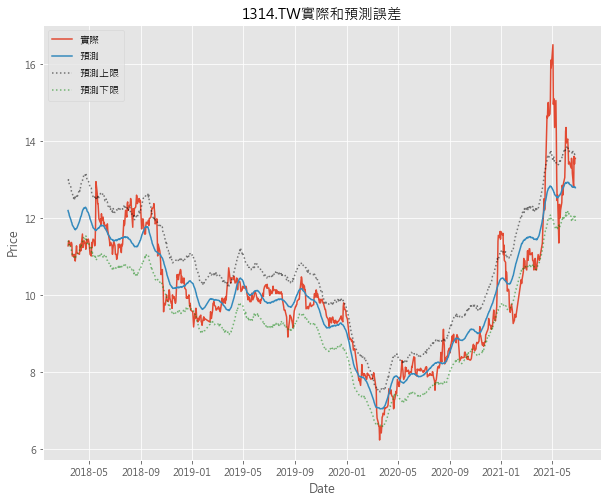

In [10]:
# 繪圖
fig,ax1 = plt.subplots(figsize=(10, 8))
ax1.plot(two_years['Adj Close'],label='實際')
ax1.plot(two_years.yhat,label='預測')
ax1.plot(two_years.yhat_upper,label='預測上限',color = 'black', linestyle = ':',alpha=0.5)
ax1.plot(two_years.yhat_lower,label='預測下限',color = 'green', linestyle = ':',alpha=0.5)
ax1.set_title(stock+'實際和預測誤差')
ax1.set_ylabel('Price')
ax1.set_xlabel('Date')
ax1.legend()
plt.show()

In [11]:
# 繪製K線圖
import talib
import mpl_finance as mpf
start = datetime.datetime(2021,1,1)
stock = str(input('請輸入繪製K線圖的股票:'))
df_stock = pdr.DataReader(stock, 'yahoo', start)
df_stock.index = df_stock.index.format(formatter=lambda x : x.strftime('%Y-%m-%d'))
# 加上10日均線與30日均線
sma_10 = talib.SMA(np.array(df_stock['Close']),10)
sma_30 = talib.SMA(np.array(df_stock['Close']),30)

# KD指標(公式請查旁邊列表)
df_stock['k'],df_stock['d'] = talib.STOCH(df_stock['High'], df_stock['Low'],
                                        df_stock['Close'])
df_stock['k'].fillna(value=0, inplace= True)
df_stock['d'].fillna(value=0, inplace= True)

C:\Users\mshome\anaconda3\lib\site-packages\mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


請輸入繪製K線圖的股票:1314.TW


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


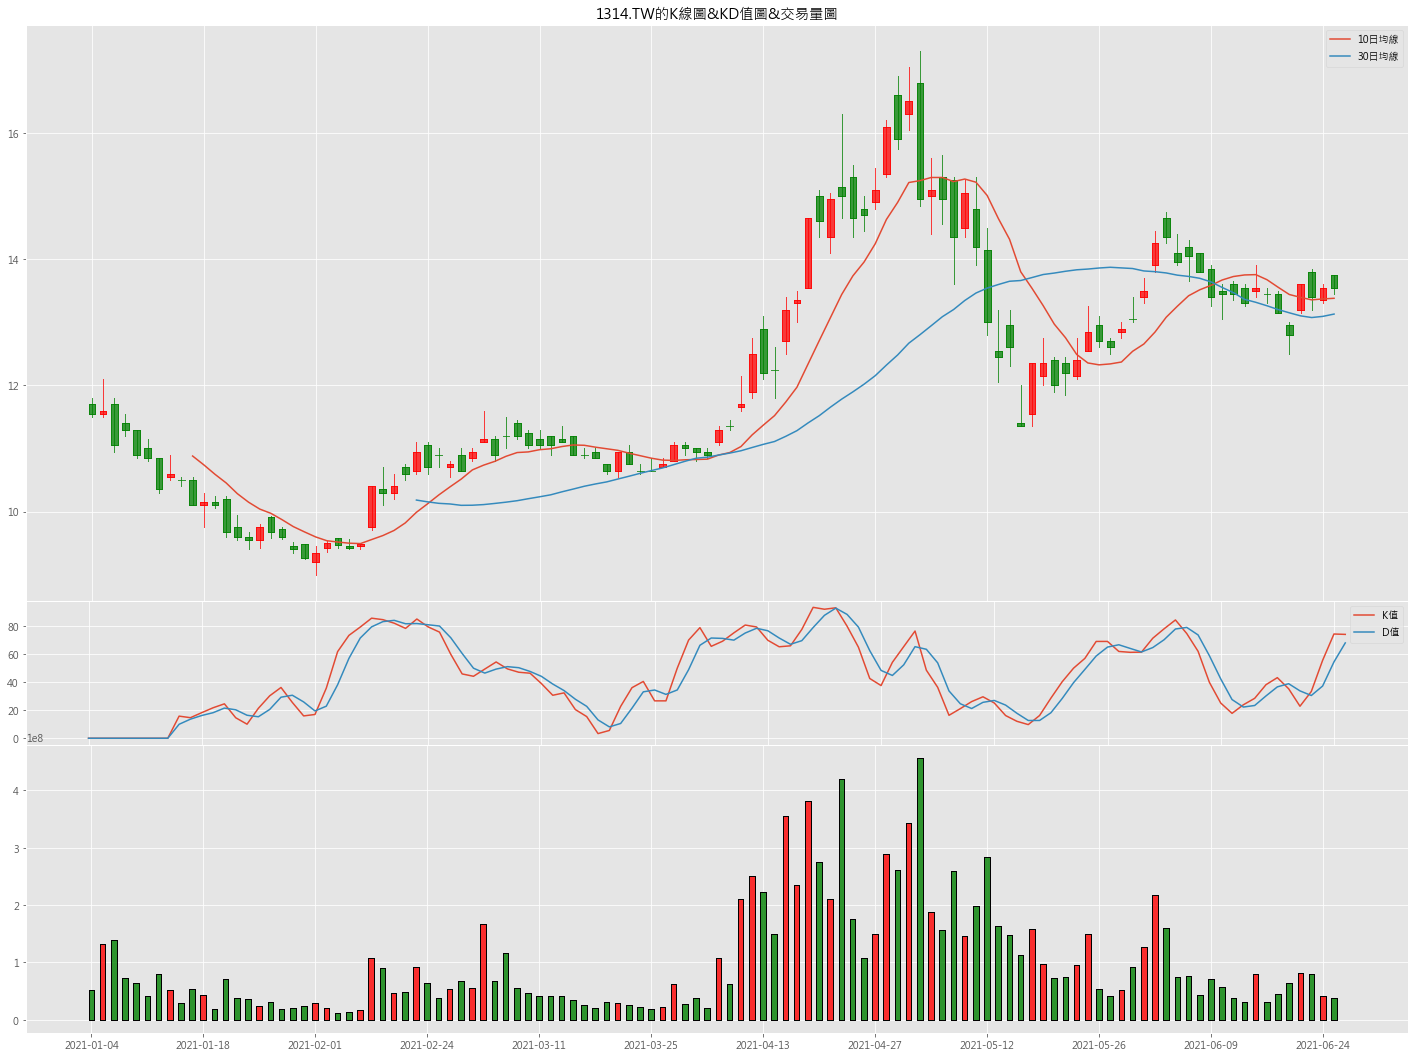

In [12]:
#繪圖
fig = plt.figure(figsize=(24, 20))
ax = fig.add_axes([0.1,0.4,0.8,0.4])
ax2 = fig.add_axes([0.1,0.3,0.8,0.1])
ax3 = fig.add_axes([0.1,0.1,0.8,0.2])
ax.set_xticks(range(0,len(df_stock.index), 10))
ax.set_xticklabels(df_stock.index[::10])
mpf.candlestick2_ochl(ax, df_stock['Open'], df_stock['Close'], df_stock['High'],
                      df_stock['Low'], width=0.6, colorup='r',colordown='g',
                      alpha=0.75)
plt.rcParams['font.sans-serif']=['Microsoft JhengHei'] 
ax.plot(sma_10, label = '10日均線')
ax.plot(sma_30, label = '30日均線')

ax2.plot(df_stock['k'],label='K值')
ax2.plot(df_stock['d'],label='D值')
ax2.set_xticks(range(0,len(df_stock.index), 10))
ax2.set_xticklabels(df_stock.index[::10]) 

mpf.volume_overlay(ax3, df_stock['Open'], df_stock['Close'], df_stock['Volume'],
                   width=0.5, colorup='r', colordown='g', alpha=0.8)
ax3.set_xticks(range(0,len(df_stock.index), 10))
ax3.set_xticklabels(df_stock.index[::10])
ax.legend()
ax2.legend()
ax.set_title(stock+"的K線圖&KD值圖&交易量圖")

In [13]:
start = datetime.datetime(2015, 1 ,1)
stock = str(input('請輸入投資的股票:'))
df_stock = pdr.DataReader(stock, 'yahoo',start)

# 收盤價和第一天的收盤價的比較

df_stock['normalized_price'] = df_stock['Adj Close']/df_stock['Adj Close'].iloc[0]
print(df_stock.head())

請輸入投資的股票:1314.TW
                 High        Low       Open      Close       Volume  \
Date                                                                  
2015-01-05  11.666666  10.904761  11.000000  11.571428  105299250.0   
2015-01-06  11.952380  11.238095  11.428571  11.857142   98024850.0   
2015-01-07  12.190476  11.619047  11.904761  11.619047   83179950.0   
2015-01-08  12.000000  11.714285  11.714285  11.761904   61997250.0   
2015-01-09  11.904761  11.619047  11.809523  11.666666   45198300.0   

            Adj Close  normalized_price  
Date                                     
2015-01-05  10.662335          1.000000  
2015-01-06  10.925603          1.024691  
2015-01-07  10.706213          1.004115  
2015-01-08  10.837847          1.016461  
2015-01-09  10.750092          1.008230  


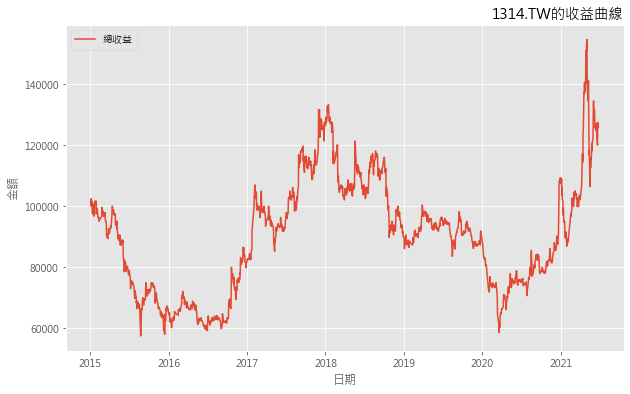

In [14]:
# 資產分配
# 我們將我們的投資金額用以下的比例分配
# 之後將分配到的比例乘上每一日的收益率
# stock 100%
weight=1
df_stock['weighted daily return']=df_stock['normalized_price']*weight
# 將股票的收益率乘上你要投資的總金額，現在假設是10萬
df_stock['Total Pos']= df_stock['weighted daily return']*100000
# 將剛剛總收益繪製圖表
fig = plt.figure(figsize=(10,6))
plt.plot(df_stock['Total Pos'], '-', label = '總收益')
plt.title(stock+'的收益曲線', loc='right')
plt.xlabel('日期')
plt.ylabel('金額')
plt.grid(True, axis = 'y')
plt.legend()

累積收益率: 0.27082854625411956
平均收益率 0.00034610802688669244
收益率標準差 0.01975133969808268


C:\Users\mshome\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


C:\Users\mshome\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\mshome\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


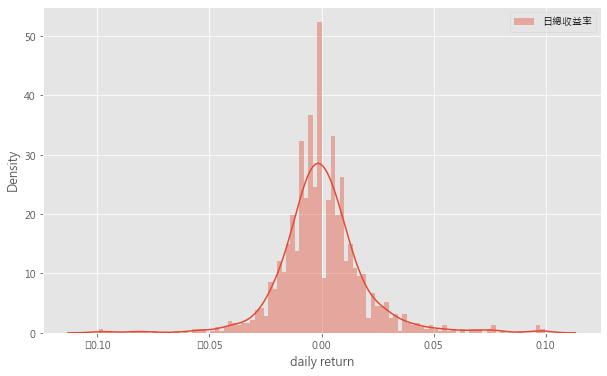

In [15]:
# 日收益率
df_stock['daily return']=df_stock['weighted daily return'].pct_change()
# 累積收益率
print("累積收益率:",df_stock['weighted daily return'].iloc[-1]/df_stock['weighted daily return'].iloc[0]-1)
# 平均日收益率
print("平均收益率",df_stock['daily return'].mean())
# 收益率標準差
print("收益率標準差",df_stock['daily return'].std())
# 使用密度圖來顯示日收益率
import seaborn as sns
fig = plt.figure(figsize=(10,6))
sns.distplot(df_stock['daily return'].dropna(),bins=100, label='日總收益率')
plt.legend()

In [22]:
# 夏普指數(Sharpe ratio)
SR = df_stock['daily return'].mean()/df_stock['daily return'].std()
print(stock+'夏普指數',SR)
# 一年總共有252天的交易日
ASR = np.sqrt(252)*SR
print(stock+'風險%',ASR)


print('代表投資者每增加','%.2f'%(ASR),"%",'的風險可以換來','%.2f'%(SR*100),"%")

1314.TW夏普指數 0.01752326840494218
1314.TW風險% 0.27817326213907495
代表投資者每增加 0.28 % 的風險可以換來 1.75 %
